In [11]:
import networkx as nx
import matplotlib.pyplot as plt

class GraphVisualization:
   
    def __init__(self):
        self.visual = []
          
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    def visualize(self):
        G = nx.DiGraph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
  
from ortools.linear_solver import pywraplp
import seaborn as sns
import pandas as pd
import numpy as np 
import time 


class WelfareSolver:
    def __init__(self, n:int, m:int, b:float, v:np.ndarray)->None:
        """
        (object initializer)
        initialises the parameters for the allocation problem 
        -----------------------------------------------------
        n : number of agents 
        m : number of items 
        b : budget to fund subsidies
        v : valuation profile for the agents
        -----------------------------------------------------
        """
        self.n = n 
        self.m = m 
        self.b = b 

        shape = v.shape
        if(shape[0]!=n and shape[1]!=m):
            raise ValueError("check the valuation profile dimensions")
        
        self.v = v 
        self.solver = pywraplp.Solver.CreateSolver('SCIP')

        if not self.solver: 
            return None 

    def create_vars(self):
        """
        (helper function)
        create the modelling variables for the problem. 
        -------------------------------------------------------------------------------------------------------------------------
        1. assignment variables ($x_{ij}$): binary in nature (signifies whether object j is alloted to agent i)
        2. subsidy variables ($p_{i}$): numerical, continious (signifies the subsidy alloted to agent i to make system envy free)
        -------------------------------------------------------------------------------------------------------------------------
        """
        self.assign_vars = []
        self.subsidy_vars = []

        s = time.time()
        for i in range(self.n):
            assign_matrix_row = []
            for j in range(self.m):
                assign_matrix_row.append(self.solver.IntVar(0, 1, f"x_({i}, {j})"))

            self.assign_vars.append(assign_matrix_row)
            self.subsidy_vars.append(self.solver.NumVar(0, self.b, f"p_{i}"))

        e = time.time()

        return e-s 

    def create_assign_constraints(self, j:int):
        """
        (helper function)
        creates the assignment constraint, one agent for one item. 
        ----------------------------------------------------------
        - \sum_{i \in [n]} x_{ij} = 1 \forall j 
        ----------------------------------------------------------
        """
        s = time.time()
        self.solver.Add(sum([self.assign_vars[i][j] for i in range(self.n)])==1)
        e = time.time()
        return e-s

    def create_subsidy_constraint(self, subsidy_bound = False, subsidy_strict=False):
        """
        (helper function)
        creates the subsidy constraint, total subsidy must be less than equal to budget 
        -------------------------------------------------------------------------------
        - \sum{i \in [n]} p_{i} \leq b 
        -------------------------------------------------------------------------------
        """
        s = time.time()
        if(subsidy_strict):
            self.solver.Add(sum(self.subsidy_vars)==self.b)
        else:
            self.solver.Add(sum(self.subsidy_vars)<=self.b)

        if(subsidy_bound):
            for i in range(self.n):
                self.solver.Add(self.subsidy_vars[i]<=1)
        e = time.time()
        return e-s

    def create_envy_constraint(self, i1, i2):
        """
        (helper function)
        creates the envy constraint for a pair of agents 
        -------------------------------------------------------------------------------
        - value of allocated bundle to agent 1 + subsidy of agent 1 >= 
        value of bundle allocated to agent 2 percieved by agent 1 + subsidy of agent 2
        -------------------------------------------------------------------------------
        """
        s = time.time()
        envy = self.subsidy_vars[i1] - self.subsidy_vars[i2] + sum([self.v[i1][j]*self.assign_vars[i1][j] - self.v[i1][j]*self.assign_vars[i2][j] for j in range(self.m)])
        self.solver.Add(envy>=0)
        e = time.time()
        return e-s

    def get_bundle_value(self, i):
        """
        (helper function)
        get the bundle value allocated to agent - i
        -------------------------------------------
        """
        return sum([self.v[i][j] * self.assign_vars[i][j] for j in range(self.m)])

    def create_objective(self):
        """
        (helper function)
        get the social welfare value for the problem
        --------------------------------------------
        """
        s = time.time()
        obj = sum([self.get_bundle_value(i) for i in range(self.n)])
        self.solver.Maximize(obj)
        e = time.time()
        return e-s

    def execute(self, show_outputs=True, sub_bound = False, sub_strict = False):
        if not self.solver:
            return None 

        else:
            t1 = self.create_vars()
            print(f" created modelling variables : {t1} miliseconds elpased")

            s = time.time()
            for i in range(self.m):
                self.create_assign_constraints(i)
            e = time.time()
            print(f" created assignment constraint : {e-s} miliseconds elapsed")

            t3 = self.create_subsidy_constraint(subsidy_bound=sub_bound,
                                                subsidy_strict=sub_strict 
                                            )
            print(f" created subsidy constraint : {t3} miliseconds elapsed")

            s = time.time()
            for i in range(self.n):
                for j in range(self.n):
                    if(i!=j):
                        self.create_envy_constraint(i, j)

            e = time.time()
            print(f" created envy constraints : {e-s} miliseconds elapsed")


            t5 = self.create_objective()
            print(f" created objective function : {t5} miliseconds elpased")

            status = self.solver.Solve()

            if status == pywraplp.Solver.OPTIMAL:
                print('optimal welfare value =', self.solver.Objective().Value())

                if(show_outputs): 
                    for i in range(self.n):
                        c = 0 
                        for j in range(self.m):
                            print(self.assign_vars[i][j].name(), ' = ', self.assign_vars[i][j].solution_value(), end='|')
                            c+=1
                            if(c==5):
                                c = 0
                                print(" ")

                        print("")

                    for i in range(self.n):
                        print(self.subsidy_vars[i].name(), ' = ', self.subsidy_vars[i].solution_value())

                    print('Problem solved in %f milliseconds' % self.solver.wall_time())
                    print('Problem solved in %d iterations' % self.solver.iterations())
                    print('Problem solved in %d branch-and-bound nodes' % self.solver.nodes())

                else:

                    gv = GraphVisualization()
                    for i in range(self.n):
                        for j in range(self.m):
                            if(self.assign_vars[i][j].solution_value()==1):
                                gv.addEdge(f"a_{i}", f"b_{j}")

                    gv.visualize()

                    subs = [self.subsidy_vars[i].solution_value() for i in range(self.n)]
                    df1 = pd.DataFrame({
                        "agent number": [i for i in range(self.n)],
                        "subsidy value" : subs
                    })
                    
                    df1.to_csv('subsidy_data.csv')

                    alloc = []
                    for i in range(self.n):
                        item_list = []
                        for j in range(self.m):
                            if(self.assign_vars[i][j].solution_value()):
                                item_list.append([j])

                        alloc.append(item_list)

                    df2 = pd.DataFrame({
                        "agent number": [i for i in range(self.n)],
                        "bundle items" : [alloc[i] for i in range(self.n)]
                    })
                    df2.to_csv('allocation_data.csv')
                    
            else:
                print('The problem does not have an optimal solution.')

 created modelling variables : 0.0001010894775390625 miliseconds elpased
 created assignment constraint : 0.00036025047302246094 miliseconds elapsed
 created subsidy constraint : 3.0994415283203125e-05 miliseconds elapsed
 created envy constraints : 0.026327848434448242 miliseconds elapsed
 created objective function : 0.0014879703521728516 miliseconds elpased
optimal welfare value = 8.725677475060555
x_(0, 0)  =  1.0|x_(0, 1)  =  0.0|x_(0, 2)  =  0.0|x_(0, 3)  =  0.0|x_(0, 4)  =  0.0| 
x_(0, 5)  =  0.0|x_(0, 6)  =  0.0|x_(0, 7)  =  1.0|x_(0, 8)  =  0.0|x_(0, 9)  =  0.0| 

x_(1, 0)  =  0.0|x_(1, 1)  =  0.0|x_(1, 2)  =  0.0|x_(1, 3)  =  0.0|x_(1, 4)  =  0.0| 
x_(1, 5)  =  0.0|x_(1, 6)  =  0.0|x_(1, 7)  =  0.0|x_(1, 8)  =  0.0|x_(1, 9)  =  0.0| 

x_(2, 0)  =  0.0|x_(2, 1)  =  0.0|x_(2, 2)  =  0.0|x_(2, 3)  =  0.0|x_(2, 4)  =  0.0| 
x_(2, 5)  =  0.0|x_(2, 6)  =  0.0|x_(2, 7)  =  0.0|x_(2, 8)  =  0.0|x_(2, 9)  =  0.0| 

x_(3, 0)  =  0.0|x_(3, 1)  =  1.0|x_(3, 2)  =  0.0|x_(3, 3)  =  0.0|x_

<AxesSubplot:>

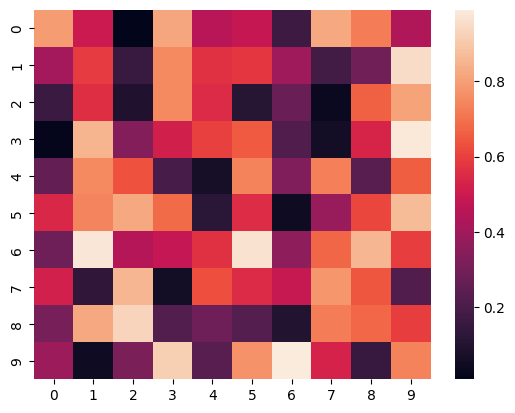

In [12]:
v1 = np.random.rand(10, 10)
ws1 = WelfareSolver(10, 10, 9, v1)
ws1.execute(show_outputs=True, sub_bound=False, sub_strict=False)
sns.heatmap(v1)

 created modelling variables : 0.00012803077697753906 miliseconds elpased
 created assignment constraint : 0.0004150867462158203 miliseconds elapsed
 created subsidy constraint : 3.6716461181640625e-05 miliseconds elapsed
 created envy constraints : 0.03160595893859863 miliseconds elapsed
 created objective function : 0.0016827583312988281 miliseconds elpased
optimal welfare value = 8.85589784508282


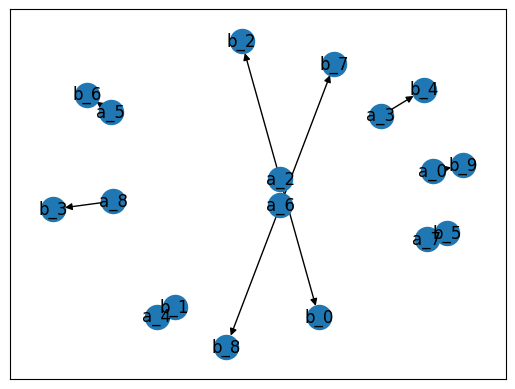

<AxesSubplot:>

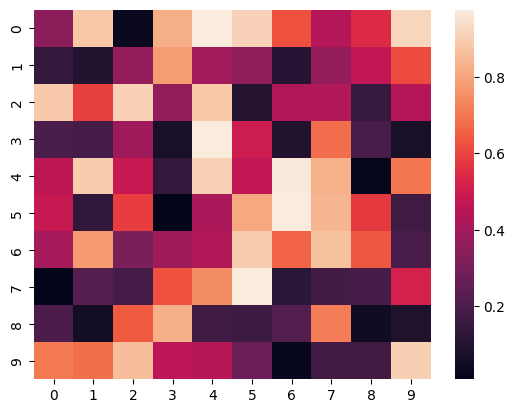

In [13]:
v2 = np.random.rand(10, 10)
ws2 = WelfareSolver(10, 10, 9, v2)
ws2.execute(show_outputs=False, sub_bound=False, sub_strict=False)

sns.heatmap(v2)

 created modelling variables : 0.00011801719665527344 miliseconds elpased
 created assignment constraint : 0.0004019737243652344 miliseconds elapsed
 created subsidy constraint : 7.390975952148438e-05 miliseconds elapsed
 created envy constraints : 0.030193090438842773 miliseconds elapsed
 created objective function : 0.0014781951904296875 miliseconds elpased
optimal welfare value = 8.143465851936847


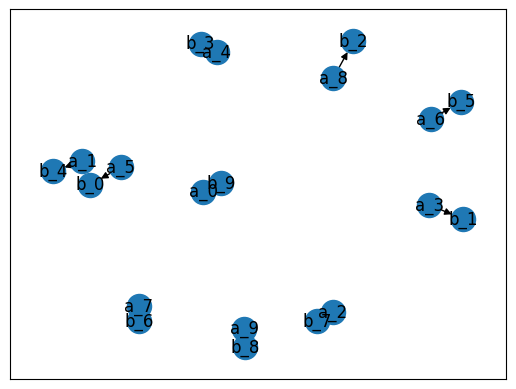

<AxesSubplot:>

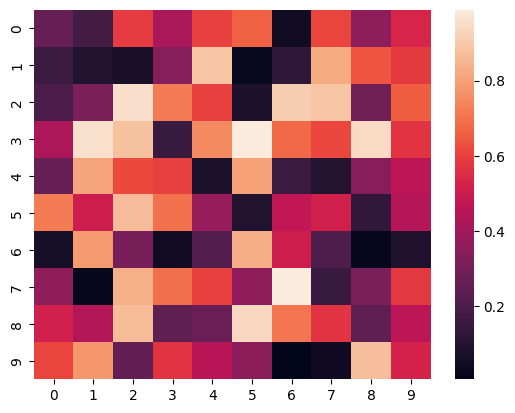

In [14]:
v3 = np.random.rand(10, 10)
ws3 = WelfareSolver(10, 10, 9, v3)
ws3.execute(show_outputs=False, sub_bound=True, sub_strict=False)

sns.heatmap(v3)

 created modelling variables : 0.00011992454528808594 miliseconds elpased
 created assignment constraint : 0.0003540515899658203 miliseconds elapsed
 created subsidy constraint : 3.0040740966796875e-05 miliseconds elapsed
 created envy constraints : 0.026327133178710938 miliseconds elapsed
 created objective function : 0.0015769004821777344 miliseconds elpased
optimal welfare value = 9.121174331578274


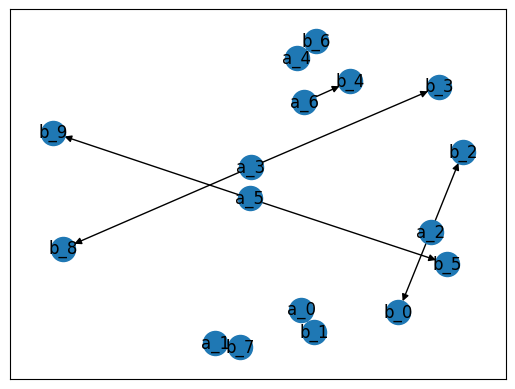

<AxesSubplot:>

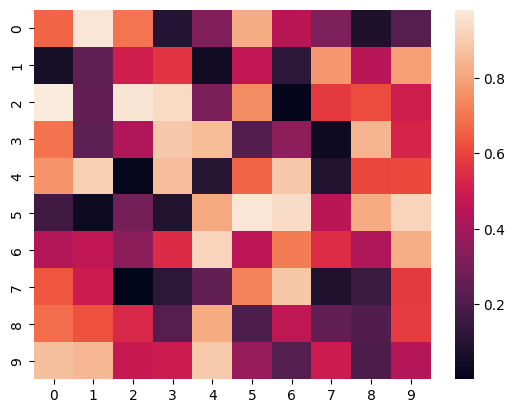

In [15]:
v4 = np.random.rand(10, 10)
ws4 = WelfareSolver(10, 10, 9, v4)
ws4.execute(show_outputs=False, sub_bound=False, sub_strict=True)

sns.heatmap(v4)

 created modelling variables : 0.0001678466796875 miliseconds elpased
 created assignment constraint : 0.0006020069122314453 miliseconds elapsed
 created subsidy constraint : 8.296966552734375e-05 miliseconds elapsed
 created envy constraints : 0.027090072631835938 miliseconds elapsed
 created objective function : 0.0015537738800048828 miliseconds elpased
optimal welfare value = 8.485752484617931


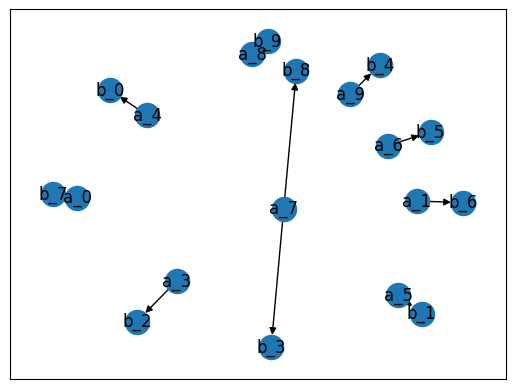

<AxesSubplot:>

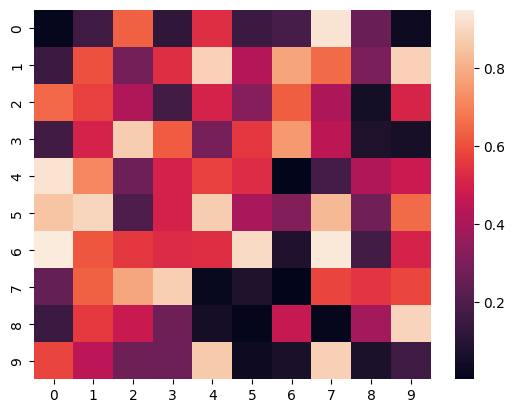

In [17]:
v5 = np.random.rand(10, 10)
ws5 = WelfareSolver(10, 10, 9, v5)
ws5.execute(show_outputs=False, sub_bound=True, sub_strict=False)

sns.heatmap(v5)